<a href="https://colab.research.google.com/github/kunai-3txk/Prediction-of-seriously-ill-patients/blob/main/BaseLine_featureselect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import

In [1]:
!pip install catboost
!pip install polars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 35.0 MB/s eta 0:00:00


In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import os
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore", message="Device used : cpu", category=UserWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import polars as pl

import xgboost as xgb
import seaborn as sns; sns.set()


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score



from imblearn.under_sampling import RandomUnderSampler

import lightgbm as lgb #LightGBM
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier,Pool

#config

In [17]:
class config:
    RANDOM_STATE=100  
    FRAC = 0.2
    N_FOLD = 3
    N_BAGGING = 3
    UNDER_SAMPLING = True
    
class paths:
    # kaggle環境ならTrue
    if 'KAGGLE_URL_BASE' in set(os.environ.keys()):
        common_path = "/kaggle/input/amp-parkinsons-disease-progression-prediction"
    
    # colaboratory環境ならTrue
    if 'COLAB_GPU' in set(os.environ.keys()):
        common_path = "/content/drive/MyDrive/ill"
    
    SUBMISSION = common_path + "/submission.csv"
    TRAIN = common_path + "/train_df.csv"
    TEST = common_path + "/test_df.csv"
    SUB_OUT = common_path + "/sub/"
     

#def

#Load Data

In [4]:
train = pd.read_csv(paths.TRAIN)
print('train shape:',train.shape)

test = pd.read_csv(paths.TEST)
print('test shape:',test.shape)

submission = pd.read_csv(paths.SUBMISSION)
print('submission shape:',submission.shape)

train shape: (51359, 85)
test shape: (12840, 84)
submission shape: (12840, 2)


# Data Clean

In [ ]:
target_col = ['target_label']

num_cols = ['age', 'bmi', 'height', 'weight', 'icu_4', 'icu_6'
            ,'glasgow_coma_scale_1', 'glasgow_coma_scale_2','glasgow_coma_scale_3', 'glasgow_coma_scale_4'
            , 'heart_rate', 'blood_oxy', 'arterial_pressure',
            'respiratory_rate', 'temp'
            , 'blood_pressure_1', 'blood_pressure_2', 'blood_pressure_3', 'blood_pressure_4',
            'v1_heartrate_max'
            , 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14','v15', 'v16'
            , 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14','w15', 'w16', 'w17', 'w18'
            , 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

# id, personal_id_1, personal_id_2 以外のカテゴリー変数
whole_cat_cols = [c for c in test.columns if c not in num_cols and c not in ['id', 'personal_id_1', 'personal_id_2']]

#for c in whole_cat_cols:
#  print(c,":",train[c].nunique())

low_cat_cols = [] # nunique が比較的少ない変数
high_cat_cols = [] # nunique が多い変数

for c in whole_cat_cols:
    nunq = train[c].nunique()
    if nunq >= 10:
        high_cat_cols.append(c)
    else:
        low_cat_cols.append(c)

for c in low_cat_cols:
    print(f"{c}:\t{train[c].unique()}")
for c in high_cat_cols:
    print(f"{c}:\t{train[c].unique()}")


print(high_cat_cols)
print(low_cat_cols)

## dict for label-encoding

In [6]:
# Label Encoding用の辞書
# uniqueが0,1,nanだけの場合は不要
# 出現頻度でソートしてラベリングする
ethnicity_list = train['ethnicity'].value_counts().sort_values(ascending=False).index
ethnicity_dic = dict(zip(ethnicity_list, range(len(ethnicity_list))))

gender_dic = {'M':0, 'F':1}

icu1_list = train['icu_1'].value_counts().sort_values(ascending=False).index
icu1_dic = dict(zip(icu1_list, range(len(icu1_list))))

icu2_list = train['icu_2'].value_counts().sort_values(ascending=False).index
icu2_dic = dict(zip(icu2_list, range(len(icu2_list))))

icu3_list = train['icu_3'].value_counts().sort_values(ascending=False).index
icu3_dic = dict(zip(icu3_list, range(len(icu3_list))))

icu5_list = train['icu_5'].value_counts().sort_values(ascending=False).index
icu5_dic = dict(zip(icu5_list, range(len(icu5_list))))

# 'body_system_1 と 'body_system_1 はその組み合わせに対してLabel Encoding
_ser = train['body_system_1'].fillna('NA') + '_' + train['body_system_2'].fillna('NA')
bs_list = _ser.value_counts().sort_values(ascending=False).index
bs_dic = dict(zip(bs_list, range(len(bs_list))))

# Count Encoding用にvalue_countsを用意(辞書として使う)
vc_facility = train['facility_id'].value_counts()
vc_icu = train['icu_id'].value_counts()
vc_ethnicity = train['ethnicity'].value_counts()
vc_icu_3 = train['icu_3'].value_counts()
vc_icu_5 = train['icu_5'].value_counts()
vc_bs = _ser.value_counts() #body_system

## nmf

In [105]:
#https://qiita.com/nozma/items/d8dafe4e938c43fb7ad1



## base_encoder

In [102]:
def nmf_encoder(df_mat):

  #とりあえず
  df_mat_ = df_mat.fillna(0)

  mmscaler = MinMaxScaler(feature_range=(0,1), copy=True)
  mmscaler.fit(df_mat_.astype('float'))
  df_mat_scaled = pd.DataFrame(mmscaler.transform(df_mat_))

  df_mat_scaled.columns = df_mat_.columns

  #df_mat.describe()
  #df_mat_scaled.describe()
  #print(df_mat_scaled.shape)

  N_COMP = 30

  # NMFによる次元削減
  model = NMF(n_components=N_COMP, init='random', random_state=config.RANDOM_STATE)
  embedded = model.fit_transform(df_mat_scaled)

  df_nmf = pd.DataFrame(embedded, columns=["NMF_comp{}".format(i) for i in range(1, N_COMP+1)])
  #print(df_nmf.shape)

  df_mat = df_mat.join(df_nmf)

  return df_mat

def base_encoder(input_df):
    out_df = input_df[num_cols].copy()

    out_df['age_int'] = out_df['age'].round(-1)
    #col組み合わせ

    #out_df['MULTI_x5_x6'] = np.nan_to_num(out_df['x5'], nan=1) * np.nan_to_num(out_df['x6'], nan=1)
    #out_df['MULTI_x5_v10'] = np.nan_to_num(out_df['x5'], nan=1) * np.nan_to_num(out_df['v10'], nan=1)
    #out_df['MULTI_x5_v12'] = np.nan_to_num(out_df['x5'], nan=1) * np.nan_to_num(out_df['v12'], nan=1)
    #out_df['MULTI_x6_v10'] = np.nan_to_num(out_df['x5'], nan=1) * np.nan_to_num(out_df['v10'], nan=1)
    #out_df['MULTI_x6_v12'] = np.nan_to_num(out_df['x5'], nan=1) * np.nan_to_num(out_df['v12'], nan=1)

    out_df['DIV_x5_x6'] = out_df['x5'] / (0.001 + out_df['x6'] )
    out_df['DIV_v10_v12'] = out_df['v10'] / (0.001 + out_df['v12'] )

    #out_df['glasgow_coma_scale_sum'] = out_df['glasgow_coma_scale_1'] + out_df['glasgow_coma_scale_2'] + out_df['glasgow_coma_scale_3'] + out_df['glasgow_coma_scale_4'] 
    out_df['glasgow_coma_scale_sum'] = out_df['glasgow_coma_scale_1'] + out_df['glasgow_coma_scale_2'] + out_df['glasgow_coma_scale_4'] 
    out_df['blood_pressure_sum'] = out_df['blood_pressure_1'] + out_df['blood_pressure_2'] + out_df['blood_pressure_3'] + out_df['blood_pressure_4'] 
    #out_df['blood_pressure_avg'] = out_df['blood_pressure_sum'] / 4 
    out_df['multi_age_res-rate'] = np.nan_to_num(out_df['age'], nan=1) * np.nan_to_num(out_df['respiratory_rate'], nan=1)

    #Label Encoding
    out_df['LE_situation_1'] = input_df['situation_1'].copy()
    out_df['LE_situation_2'] = input_df['situation_2']
    out_df['LE_ethnicity'] = input_df['ethnicity'].map(ethnicity_dic)
    out_df['LE_gender'] = input_df['gender'].map(gender_dic)
    out_df['LE_icu_1'] = input_df['icu_1'].map(icu1_dic)
    out_df['LE_icu_2'] = input_df['icu_2'].map(icu2_dic)
    out_df['LE_icu_3'] = input_df['icu_3'].map(icu3_dic)
    out_df['LE_icu_5'] = input_df['icu_5'].map(icu5_dic)
    out_df['LE_icu_7'] = input_df['icu_7'].copy()
    out_df['LE_icu_8'] = input_df['icu_8']
    out_df['num_disease'] = 0   # 持病の数
    for c in ['aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma']:
        out_df['LE_'+c] = input_df[c]
        out_df['num_disease'] += input_df[c]
    out_df['body_system'] = input_df['body_system_1'].fillna('NA') + '_' + input_df['body_system_2'].fillna('NA')
    out_df['LE_body_system'] = out_df['body_system'].map(bs_dic)
    out_df['CE_facility'] = input_df['facility_id'].map(vc_facility)
    out_df['CE_icu'] = input_df['icu_id'].map(vc_icu)
    out_df['CE_facility'] = input_df['facility_id'].map(vc_facility)
    out_df['CE_ethnicity'] = input_df['ethnicity'].map(vc_ethnicity)
    out_df['CE_icu_3'] = input_df['icu_3'].map(vc_icu_3)
    out_df['CE_icu_5'] = input_df['icu_5'].map(vc_icu_5)
    out_df['CE_body_system'] = out_df['body_system'].map(vc_bs)

    out_df['DIV_x5_LE_hepatic_issue'] = out_df['x5'] / ( 0.001 + out_df['LE_hepatic_issue'] )
    out_df['DIV_x3_x6'] = out_df['x3'] / ( 0.001 + out_df['x6'] )
    out_df['DIV_x3_x5'] = out_df['x3'] / ( 0.001 + out_df['x5'] )
    out_df['DIV_w6_x5'] = out_df['w6'] / ( 0.001 + out_df['x6'] )
    out_df['DIV_x4_x5'] = out_df['x4'] / ( 0.001 + out_df['x5'] )
    out_df['DIV_x1_num_disease'] = out_df['x1'] / ( 0.001 + out_df['num_disease'] )
    out_df['DIV_v1_heartrate_max_x6'] = out_df['v1_heartrate_max'] / ( 0.001 + out_df['x6'] )
    out_df['DIV_x1_x5'] = out_df['x1'] / ( 0.001 + out_df['x5'] )
    out_df['DIV_x5_LE_leukemia'] = out_df['x5'] / ( 0.001 + out_df['LE_leukemia'] )
    out_df['DIV_x5_LE_icu_8'] = out_df['x5'] / ( 0.001 + out_df['LE_icu_8'] )
    out_df['DIV_age_x6'] = out_df['age'] / ( 0.001 + out_df['x6'] )


    #不要行の削除
    out_df.drop('body_system', axis=1,inplace=True)

    # l1 = out_df.columns
    # l2 =[]
    # for c in l1:
    #   if out_df[c].nunique() >= 120:
    #     l2.append(c)
    # l2 = ['x5','x6','LE_situation_2','blood_oxy','v1_heartrate_max',
    #       'w11','x3','w5','w12','age',
    #       'heart_rate','v7','w6','respiratory_rate','x1','icu_4',
    #       'CE_icu_5','glasgow_coma_scale_3','LE_carcinoma'
    #       ,'LE_icu_1','LE_cirrhosis','LE_hepatic_issue','LE_immunosuppression','num_disease','LE_icu_8','LE_leukemia','v8','x4','CE_body_system']
    # for c1 in l2:
    #   for c2 in l2:
    #     col_name_M = 'MULTI_'+str(c1)+'_'+str(c2)
    #     col_name_D = 'DIV_'+str(c1)+'_'+str(c2)
        #out_df[col_name_M] =  out_df[c1] * out_df[c2]
        #out_df[col_name_D] =  out_df[c1] /(0.001 +  out_df[c2])
      
    out_df = nmf_encoder(out_df)

    #return out_df.drop('body_system', axis=1)
    return out_df

## trial

nunique >= 120の結果
'MULTI_v16_v15', 'v4', 'MULTI_v15_v16','MULTI_v16_temp','MULTI_v15_v15',  'MULTI_v14_icu_6','MULTI_icu_6_v12', 'MULTI_icu_6_height', 'MULTI_icu_6_v16',
相関係数では「heartrate_max」関連が高め

相関係数top30 DIV
'DIV_x5_LE_hepatic_issue','DIV_x3_x6', 'DIV_x3_x5', 'DIV_w6_x5'
'DIV_x4_x5','DIV_x5_w6', 'v6', 'DIV_x1_num_disease'
'DIV_v1_heartrate_max_x6', 'DIV_x1_x5', 'DIV_x5_LE_leukemia',
'DIV_x5_LE_icu_8','DIV_age_x6'],



In [8]:
# l = X_train.columns
# l2 =[]
# for c in l:
#   if X_train[c].nunique() >= 120:
#     l2.append(c)

# print(len(l2),l2)



In [9]:
# train_df = pd.concat([X_train,y_train],axis=1)
# train_corr = train_df.corr()
# target_df = train_corr[['target_label']]
# sort_df_de = target_df.sort_values('target_label', ascending=False)
# tmp = sort_df_de.iloc[0:30, :].reset_index()
# tmp_list = list(tmp['index'].values)
# tmp_list.remove('target_label')

#Fit

## LGBM

In [103]:
X_train = base_encoder(train)
y_train = train['target_label']
test_X = base_encoder(test)

/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


0.87706


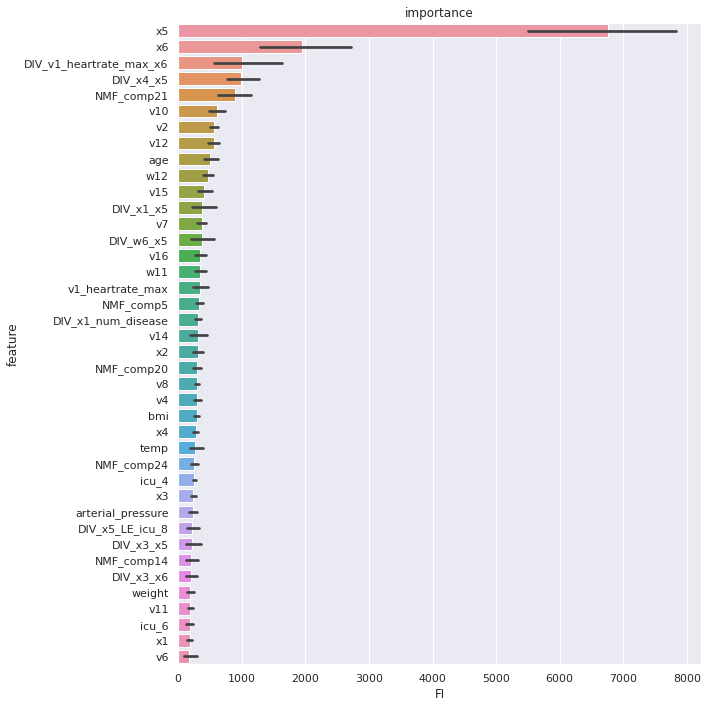

In [104]:


#****************************

models = []                     
preds = np.zeros(len(test))
scores = 0.0   
best_score = -1
fi_df = pd.DataFrame()
oof = np.zeros(len(X_train))

#_train, X_valtest, y_train, y_valtest = train_test_split(train_X,train_y,test_size=config.FRAC,random_state=config.RANDOM_STATE)
skf = StratifiedKFold(n_splits=config.N_FOLD, shuffle=True,random_state=config.RANDOM_STATE)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train)): 
  X_trn, y_trn = X_train.loc[trn_idx], y_train[trn_idx]
  X_val, y_val = X_train.loc[val_idx], y_train[val_idx]

  for bag in range(config.N_BAGGING):

    rus = RandomUnderSampler(random_state=config.RANDOM_STATE, replacement=True)
    if config.UNDER_SAMPLING:
      X_trn, y_trn = rus.fit_resample(X_trn, y_trn)

    # モデルの学習
    model = lgb.LGBMClassifier(importance_type='gain')
    # model = lgb.LGBMClassifier(n_estimators=30000,
    # max_depth=5,
    # colsample_bytree=0.5,
    # learning_rate=0.06,
    # importance_type='gain',
    # random_state=config.RANDOM_STATE)
    model.fit(X_trn, y_trn
              ,eval_metric='auc' 
              ,eval_set=[(X_val, y_val)]
              ,callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
              )
    # train_pool = Pool(X_trn, y_trn)
    # validate_pool = Pool(X_val, y_val) 

    # model = CatBoostClassifier(custom_loss=['AUC'],random_seed=config.RANDOM_STATE,logging_level='Silent')
    # model.fit(train_pool,eval_set=validate_pool
    #           ,early_stopping_rounds=10,use_best_model=True,plot=False,verbose=False)                 
    
    # validation データでの予測結果
    score = roc_auc_score(y_val,model.predict_proba(X_val)[:,1])
    oof[val_idx] = model.predict_proba(X_val)[:,1]
    #scores += score / (config.N_FOLD * config.N_BAGGING)
    models.append(model)

    if score > best_score:
        best_score = score
        best_model = model
        best_fold = fold+1
        best_bag = bag+1

    

      # feature_importances_の記録
    _df = pd.DataFrame()
    _df['feature'] = X_trn.columns
    _df['FI'] = model.feature_importances_
    _df['fold'] = fold
    _df['bag'] = bag
    fi_df = pd.concat([fi_df, _df])

    preds += model.predict_proba(test_X)[:,1] / (config.N_FOLD * config.N_BAGGING)

    #print("Fold :" , fold+1,"Bagging:",bag+1)

  #print("Fold :" , fold+1)

#print(f"fold best score : {best_score:.4f}"," FOLD ",best_fold,"BAG",best_bag)
tot_auc = roc_auc_score(y_train, oof)
#print(f"Overall AUC: {tot_auc:.5f}")
print(tot_auc.round(5))

# feature_importances_ 上位N個の図示
TOP = 40

order = fi_df.groupby('feature')['FI'].mean().sort_values(ascending=False)[:TOP].index
# 可視化
plt.figure(figsize=(10, 10))
sns.barplot(x="FI",y="feature",data=fi_df,order=order)
plt.title('importance')
plt.tight_layout()
plt.show()


##displot

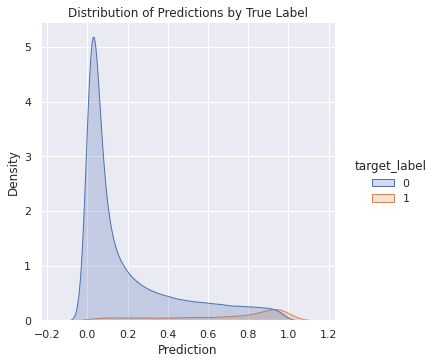

In [95]:
oof_df = pd.DataFrame({
    'oof': oof,
    'target_label':train['target_label']
})

# 'target_label'ごとの予測値の分布を可視化する
sns.displot(oof_df, x="oof", hue="target_label", kind="kde", fill=True)

# グラフのタイトルと軸ラベルを設定する
plt.title('Distribution of Predictions by True Label')
plt.xlabel('Prediction')
plt.ylabel('Density')

# グラフを表示する
plt.show()

In [14]:
submission['target_label'] = preds
#submission.to_csv(paths.SUB_OUT+'submission.csv', index=False)